# Data Preprocessing - Pairwise
- Create pairs of songs with similarity labels to help fine tune/train DL model.
- Get pairs from the last fm data set and output a dataframe of links and or spectrograms/audio files.

In [32]:
pip install -q spotipy tqdm tenacity

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import requests
import io
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import re
import json
import pickle as pkl
import base64
import time
import urllib.parse
from fuzzywuzzy import fuzz
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from requests.exceptions import ReadTimeout
from tqdm import tqdm
import sys
from tenacity import retry, wait_exponential, stop_after_attempt, RetryError

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### First Dataset: music_info_df
- Contains track labels, track name, artist, spotify preview_urls, and some other calculated features
- Size: 50,683 songs

In [3]:
music_info_df = pd.read_csv('/Users/reggiebain/erdos/song-similarity-erdos-old/data/music_info.csv')
music_info_df.head(2)

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.0,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.0,0.2070,0.651,174.426,4


In [3]:
music_info_df.shape

(50683, 21)

#### Creating Dataframe of LastFM Dataset
- Below, we calcualte the number of total json files in the last fm dataset we have
- TO DO: Create an index of these files for easy searching

In [4]:
def count_json_files(directory):
    json_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_count += 1
    return json_count

# Specify the directory you want to count JSON files in
directory = '/kaggle/input/song-similarity-msd-lastfm-covers-spotify/data/lastfm/lastfm_train'

# Count JSON files
total_json_files = count_json_files(directory)

print(f"Total number of JSON files in '{directory}': {total_json_files}")

Total number of JSON files in '/kaggle/input/song-similarity-msd-lastfm-covers-spotify/data/lastfm/lastfm_train': 839122


#### Grabbing Similar Songs w/ Similarity Scores from LastFM
- There are 839,122 json files in the lastfm dataset 
- Next, we need to grab the metatdata from these json files for our 50k music_info_df songs so we get the "similars" information which lists similarity scores.

In [27]:
# Load json files that correspond to track ids in music info dataframe
def load_json_files(directory, track_ids):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                for track_id in track_ids:
                    if file.startswith(track_id):
                        file_path = os.path.join(root, file)
                        try:
                            with open(file_path, 'r') as f:
                                try:
                                    json_content = json.load(f)
                                    # If data is a dict, wrap it in a list
                                    if isinstance(json_content, dict):
                                        data.append(json_content)
                                    elif isinstance(json_content, list):
                                        data.extend(json_content)
                                    else:
                                        print(f"Unexpected JSON structure in file: {file_path}")
                                except json.JSONDecodeError as e:
                                    print(f"Error decoding JSON in file {file_path}: {e}")
                        except Exception as e:
                            print(f"Error reading {file_path}: {e}")
    return data

In [28]:
# Your existing DataFrame with track IDs
music_info_df = pd.read_csv('/Users/reggiebain/erdos/song-similarity-erdos-old/data/music_info.csv')
# Directory containing the JSON files
directory = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/lastfm/lastfm_train'

# Get the list of track IDs
track_ids = music_info_df['track_id'].tolist()

# Load JSON files with the track IDs
json_data = load_json_files(directory, track_ids)

# Ensure all dictionaries have the same keys
if json_data:
    keys = set().union(*(d.keys() for d in json_data if isinstance(d, dict)))
    processed_data = [{k: d.get(k, None) for k in keys} for d in json_data if isinstance(d, dict)]

    # Create JSON DataFrame
    json_df = pd.DataFrame(processed_data)
    
    # Save to json
    json_df.to_pickle('last_fm_df.pkl')
    #json_df.to_json('last_fm_df.json', orient='records', lines=True)
    
else:
    print("No data was read from the JSON files.")

In [14]:
last_fm_df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos-old/data/last_fm_df.pkl')
last_fm_df.head(2)

,tags,similars,track_id,timestamp,artist,title
0,"[[classic rock, 100], [60s, 76], [british, 40]...","[[TRMLOXQ12903CF06BB, 1], [TRCOWHF128F932163D,...",TRRRRCH128F9342C72,2011-08-02 05:18:14.083535,The Kinks,A Well Respected Man
1,"[[hip hop, 100], [club, 50], [stream, 50]]","[[TRMWSGB128F422741B, 1], [TRXHRRS128F4227426,...",TRRRRBT128F422742A,2011-08-03 23:59:25.259326,Mic Geronimo,All Good


- DATASET NOTE: last_fm_df contains  44,269 entries. Each entry has a track_id from music_info_df along with information on similars, etc.

In [18]:
combined_df = pd.merge(last_fm_df, music_info_df, on='track_id', suffixes=('_lastfm', ''))
combined_df.head(2)

,tags_lastfm,similars,track_id,timestamp,artist_lastfm,title,name,artist,spotify_preview_url,spotify_id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"[[classic rock, 100], [60s, 76], [british, 40]...","[[TRMLOXQ12903CF06BB, 1], [TRCOWHF128F932163D,...",TRRRRCH128F9342C72,2011-08-02 05:18:14.083535,The Kinks,A Well Respected Man,A Well Respected Man,The Kinks,https://p.scdn.co/mp3-preview/6c55cd100c49752b...,0bqEyA4bNCrjbQqBMt6hvA,...,9,-5.050,0,0.182,0.20500,0.000000,0.0420,0.614,161.620,4
1,"[[hip hop, 100], [club, 50], [stream, 50]]","[[TRMWSGB128F422741B, 1], [TRXHRRS128F4227426,...",TRRRRBT128F422742A,2011-08-03 23:59:25.259326,Mic Geronimo,All Good,All Good,De La Soul,https://p.scdn.co/mp3-preview/2f30d5067fbb1733...,08v0AVrpiS3M7wlvpm6Tqu,...,9,-8.622,0,0.247,0.00717,0.000017,0.0201,0.747,96.801,4


In [19]:
combined_df.shape

(44269, 26)

- NOTE: At this point combined_df contains music_info_df with the similars and other metadata we found from the lastFM json files where we found

#### Extracting Similar Song TrackIDs
- Extract track_id's and similarity scores for most/least similar song where possible called sim_track_1, sim_track_last etc from the existing combined_df

In [20]:
# Function to extract first and last entries
def extract_first_and_last(similar_list):
    if not similar_list:
        return [None, None, None, None]
    first = similar_list[0] if len(similar_list) > 0 else [None, None]
    #second = similar_list[1] if len(similar_list) > 1 else [None, None]
    #third = similar_list[2] if len(similar_list) > 2 else [None, None]
    #fourth = similar_list[3] if len(similar_list) > 3 else [None, None]
    #fifth = similar_list[4] if len(similar_list) > 4 else [None, None]
    last = similar_list[-1] if len(similar_list) > 0 else [None, None]
    return [first[0], first[1], last[0], last[1]]

# Apply the function to the 'similar' column and expand the result into separate columns
combined_df[['sim_track_id_1', 'sim_rating_1', 'sim_track_id_last','sim_rating_last']] = combined_df['similars'].apply(extract_first_and_last).tolist()
combined_df.head(2)

,tags_lastfm,similars,track_id,timestamp,artist_lastfm,title,name,artist,spotify_preview_url,spotify_id,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,sim_track_id_1,sim_rating_1,sim_track_id_last,sim_rating_last
0,"[[classic rock, 100], [60s, 76], [british, 40]...","[[TRMLOXQ12903CF06BB, 1], [TRCOWHF128F932163D,...",TRRRRCH128F9342C72,2011-08-02 05:18:14.083535,The Kinks,A Well Respected Man,A Well Respected Man,The Kinks,https://p.scdn.co/mp3-preview/6c55cd100c49752b...,0bqEyA4bNCrjbQqBMt6hvA,...,0.20500,0.000000,0.0420,0.614,161.620,4,TRMLOXQ12903CF06BB,1.0,TRPPSQQ128F148C75C,0.002089
1,"[[hip hop, 100], [club, 50], [stream, 50]]","[[TRMWSGB128F422741B, 1], [TRXHRRS128F4227426,...",TRRRRBT128F422742A,2011-08-03 23:59:25.259326,Mic Geronimo,All Good,All Good,De La Soul,https://p.scdn.co/mp3-preview/2f30d5067fbb1733...,08v0AVrpiS3M7wlvpm6Tqu,...,0.00717,0.000017,0.0201,0.747,96.801,4,TRMWSGB128F422741B,1.0,TRKXYLS128F4238941,0.005103


In [21]:
combined_df.shape

(44269, 30)

- Save combined_df to pickle file. 
- It has shape 44,269 x 30, the same size as we had with last_fm_df and combined_df

In [22]:
combined_df.to_pickle('../data/combined_df.pkl')

#### ------------------- START HERE -----------------

#### Find Spotify Preview Links from JSON Info + Spotify API
- Step one is to get the metadata for each song by searching through json files
- Then we take the metadata (artist and track title) and get them from the spotify api
- START: we start with combined_df which is of size 44,269,886 x 30 and contains all of the 

In [4]:
combined_df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos-old/data/combined_df.pkl')
combined_df.head(2)

,tags_lastfm,similars,track_id,timestamp,artist_lastfm,title,name,artist,spotify_preview_url,spotify_id,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,sim_track_id_1,sim_rating_1,sim_track_id_last,sim_rating_last
0,"[[classic rock, 100], [60s, 76], [british, 40]...","[[TRMLOXQ12903CF06BB, 1], [TRCOWHF128F932163D,...",TRRRRCH128F9342C72,2011-08-02 05:18:14.083535,The Kinks,A Well Respected Man,A Well Respected Man,The Kinks,https://p.scdn.co/mp3-preview/6c55cd100c49752b...,0bqEyA4bNCrjbQqBMt6hvA,...,0.20500,0.000000,0.0420,0.614,161.620,4,TRMLOXQ12903CF06BB,1.0,TRPPSQQ128F148C75C,0.002089
1,"[[hip hop, 100], [club, 50], [stream, 50]]","[[TRMWSGB128F422741B, 1], [TRXHRRS128F4227426,...",TRRRRBT128F422742A,2011-08-03 23:59:25.259326,Mic Geronimo,All Good,All Good,De La Soul,https://p.scdn.co/mp3-preview/2f30d5067fbb1733...,08v0AVrpiS3M7wlvpm6Tqu,...,0.00717,0.000017,0.0201,0.747,96.801,4,TRMWSGB128F422741B,1.0,TRKXYLS128F4238941,0.005103


In [30]:
'''
# Funciton to get access token for spotify api
def get_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_headers = {
        'Authorization': 'Basic ' + base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode('ascii'),
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    auth_data = {'grant_type': 'client_credentials'}
    response = requests.post(auth_url, headers=auth_headers, data=auth_data)
    return response.json()['access_token']

# Function to search for track based on track name and artist name w/ rate limiter
def search_track(track_name, artist_name, access_token):
    search_url = 'https://api.spotify.com/v1/search'
    headers = {'Authorization': f'Bearer {access_token}'}
    params = {
        'q': f'track:{track_name} artist:{artist_name}',
        'type': 'track',
        'limit': 1
    }
    response = requests.get(search_url, headers=headers, params=params)
    if response.status_code == 429:
        # Rate limit exceeded, wait and retry
        retry_after = int(response.headers.get('Retry-After', 1))
        time.sleep(retry_after)
        response = requests.get(search_url, headers=headers, params=params)
    results = response.json()
    if 'tracks' in results and results['tracks']['items']:
        return results['tracks']['items'][0]['preview_url']
    return None
'''

- For each of our similar track ids we extracted, we need to get the rest of the metadata by searching for the file in our set of json files so that we can then get spotify links. 
- **Step 1:** Create index of all of the json files
- **Step 2:** Get the paths for each file so its easier to look them up.
- **Step 3:** Get the metadata (specifically the track and artist name) for each of our similar song id's (2 for each song in original music_info_df)
- **Step 4:** Use Spotify API to get preview links for every similar track. Then deal with those that we don't have previews for. Try SoundCloud.

In [5]:
## STEP 1
# Create an index of the json files
def create_file_index(directory):
    file_index = {}
    file_count = sum([len(files) for _, _, files in os.walk(directory)])
    with tqdm(total=file_count, desc="Indexing files", unit="file") as pbar:
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.json'):
                    track_id = file.split('.')[0]  # Assuming the track_id is the part before the first underscore
                    file_index[track_id] = os.path.join(root, file)
                pbar.update(1)
    
    return file_index

## STEP 2
# Function to get file path from the index
def get_file_path(track_id, file_index):
    return file_index.get(track_id, None)

In [6]:
# Create our file index of all of our jsons
directory = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/lastfm/lastfm_train'
#directory = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/lastfm'
file_index = create_file_index(directory)

Indexing files: 100%|██████████| 839153/839153 [00:22<00:00, 37933.99file/s]


In [7]:
# Create new column for sim_track_id_1
tqdm.pandas(desc="Looking up file paths", unit="row")
combined_df['sim_path_1'] = combined_df['sim_track_id_1'].progress_apply(lambda row: get_file_path(row, file_index))
combined_df['sim_path_last'] = combined_df['sim_track_id_last'].progress_apply(lambda row: get_file_path(row, file_index))
# Create new column for sim_track_id_2

combined_df.head(2)

Looking up file paths: 100%|██████████| 44269/44269 [00:00<00:00, 293607.45row/s]


,tags_lastfm,similars,track_id,timestamp,artist_lastfm,title,name,artist,spotify_preview_url,spotify_id,...,liveness,valence,tempo,time_signature,sim_track_id_1,sim_rating_1,sim_track_id_last,sim_rating_last,sim_path_1,sim_path_last
0,"[[classic rock, 100], [60s, 76], [british, 40]...","[[TRMLOXQ12903CF06BB, 1], [TRCOWHF128F932163D,...",TRRRRCH128F9342C72,2011-08-02 05:18:14.083535,The Kinks,A Well Respected Man,A Well Respected Man,The Kinks,https://p.scdn.co/mp3-preview/6c55cd100c49752b...,0bqEyA4bNCrjbQqBMt6hvA,...,0.0420,0.614,161.620,4,TRMLOXQ12903CF06BB,1.0,TRPPSQQ128F148C75C,0.002089,/Users/reggiebain/erdos/song-similarity-erdos-...,/Users/reggiebain/erdos/song-similarity-erdos-...
1,"[[hip hop, 100], [club, 50], [stream, 50]]","[[TRMWSGB128F422741B, 1], [TRXHRRS128F4227426,...",TRRRRBT128F422742A,2011-08-03 23:59:25.259326,Mic Geronimo,All Good,All Good,De La Soul,https://p.scdn.co/mp3-preview/2f30d5067fbb1733...,08v0AVrpiS3M7wlvpm6Tqu,...,0.0201,0.747,96.801,4,TRMWSGB128F422741B,1.0,TRKXYLS128F4238941,0.005103,/Users/reggiebain/erdos/song-similarity-erdos-...,/Users/reggiebain/erdos/song-similarity-erdos-...


In [8]:
## STEP 3:
# Function to extract json data from a file
def extract_json_data(file_path):
    if file_path is None or not os.path.exists(file_path):
        return {}
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Function to add the metadata from the json to the row of a df
def get_similar_song_metadata(df, name):
    tqdm.pandas(desc=f'Getting json data for {name}', unit='row')
    df['json_data'] = df[name].progress_apply(extract_json_data)

    # Expand the dictionary into separate columns
    tqdm.pandas(desc='Expanding columns', unit='row')
    json_df = df['json_data'].progress_apply(pd.Series)

    # Rename the columns with '_sim' suffix
    json_df = json_df.rename(columns=lambda x: f"{x}_{name}")

    # Concatenate the original DataFrame with the new DataFrame
    tqdm.pandas(desc='Concatenating dfs', unit='row')
    concat_df = pd.concat([df, json_df], axis=1).drop(columns=['json_data'])

    return concat_df

In [9]:
# Copy dataframe and extract the json data for similar songs
combined_wJson_1_df = get_similar_song_metadata(combined_df.copy(), 'sim_path_1')
combined_wJson_both_df = get_similar_song_metadata(combined_wJson_1_df.copy(), 'sim_path_last')
combined_wJson_both_df.head(2)

Expanding columns: 100%|██████████| 44269/44269 [00:28<00:00, 1529.65row/s]


,tags_lastfm,similars,track_id,timestamp,artist_lastfm,title,name,artist,spotify_preview_url,spotify_id,...,similars_sim_path_1,tags_sim_path_1,track_id_sim_path_1,title_sim_path_1,artist_sim_path_last,timestamp_sim_path_last,similars_sim_path_last,tags_sim_path_last,track_id_sim_path_last,title_sim_path_last
0,"[[classic rock, 100], [60s, 76], [british, 40]...","[[TRMLOXQ12903CF06BB, 1], [TRCOWHF128F932163D,...",TRRRRCH128F9342C72,2011-08-02 05:18:14.083535,The Kinks,A Well Respected Man,A Well Respected Man,The Kinks,https://p.scdn.co/mp3-preview/6c55cd100c49752b...,0bqEyA4bNCrjbQqBMt6hvA,...,"[[TRRRRCH128F9342C72, 0.907601], [TRLDBSA128F4...","[[juno, 100], [Soundtrack, 97], [alternative, ...",TRMLOXQ12903CF06BB,I'm Sticking With You,Dusty Springfield,2011-08-03 06:52:54.538682,"[[TRTEKWC128F148C760, 1], [TRKGBOM128F4282328,...","[[60s, 100]]",TRPPSQQ128F148C75C,I Am Your Child
1,"[[hip hop, 100], [club, 50], [stream, 50]]","[[TRMWSGB128F422741B, 1], [TRXHRRS128F4227426,...",TRRRRBT128F422742A,2011-08-03 23:59:25.259326,Mic Geronimo,All Good,All Good,De La Soul,https://p.scdn.co/mp3-preview/2f30d5067fbb1733...,08v0AVrpiS3M7wlvpm6Tqu,...,"[[TRRRRBT128F422742A, 1], [TRQUBJI128F4227429,...","[[mic geronimo, 100], [hip hop, 50], [undergro...",TRMWSGB128F422741B,Survive,Tonedeff,2011-08-05 07:51:24.095345,"[[TRKFHFY128F423894E, 1], [TRMXTFH128F423894D,...","[[hip hop, 100], [american hip hop, 100]]",TRKXYLS128F4238941,"Quotables (f/ Substantial, Wordsworth, PackFM,..."


In [10]:
# Save state before Step 4
combined_wJson_both_df.to_pickle('../data/combined_wJson_both_df.pkl')

------- NEW DATA FOR STEP 4 LOAD HERE --------

In [3]:
combined_wJson_both_df = pd.read_pickle('../data/combined_wJson_both_df.pkl')

In [37]:
## STEP 4: Get spotify links
from dotenv import dotenv_values

# Load stuff from .env file
env_vars = dotenv_values('.env')

client_credentials_manager = SpotifyClientCredentials(
    client_id=os.getenv("SPOTIFY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIFY_CLIENT_SECRET"),
)

# Get Spotify api client and apply to df
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [38]:
# Function to get the preview URL of a song based on artist name and song title
@retry(wait=wait_exponential(multiplier=1, min=4, max=60), stop=stop_after_attempt(10))
def search_track(artist_name, track_name, sp, rate_limit = 1.0):
    # Search for the track
    result = sp.search(q=f'artist:{artist_name} track:{track_name}', type='track', limit=1)
    if result['tracks']['items']:
        # Return the preview URL if found
        return result['tracks']['items'][0]['preview_url']
    return None

# Funciton to get spotify url's.
def get_preview_url(artist_name, track_name, sp):
    try:
        preview_url = search_track(artist_name, track_name, sp)
        return preview_url
    except RetryError:
        print(f"Failed to find preview URL for {artist_name=}, {title_name=}")
        return None

In [39]:
# Function to get batch of urls
def get_url_batch(batch_df, batch_number):
    tqdm.pandas(desc=f"Processing batch {batch_number}", unit="row")
    batch_df['spotify_preview_url_sim_1'] = batch_df.progress_apply(lambda row: get_preview_url(row['artist_sim_path_1'], row['title_sim_path_1'], sp), axis=1)
    batch_df['spotify_preview_url_sim_last'] = batch_df.progress_apply(lambda row: get_preview_url(row['artist_sim_path_last'], row['title_sim_path_last'], sp), axis=1)
    #batch_df.to_csv(f"batch_{batch_number}.csv", index=False)  # Save the batch to a CSV file
    with open(f"batch_{batch_number}.pkl", "wb") as f:
        pkl.dump(batch_df, f)  # Save the batch to a pickle file

In [40]:
import requests
import base64
import json

# Do Auth stuff
# Step 1. Authorization
auth_url = "https://accounts.spotify.com/api/token"
headers = {}
data = {}

SPOTIFY_CLIENT_ID='1291647174c2461695c6a959814b387b'
SPOTIFY_CLIENT_SECRET='54ed91cb19e64c3ca8ca58b9a5dc3342'

# Encode as Base64
message = f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}"
messageBytes = message.encode('ascii')
base64Bytes = base64.b64encode(messageBytes)
base64Message = base64Bytes.decode('ascii')

headers['Authorization'] = f"Basic {base64Message}"
data['grant_type'] = "client_credentials"
r = requests.post(auth_url, headers=headers, data=data)
token = r.json()['access_token']

headers = {
    'Authorization': 'Bearer ' + token
}


search_term = "Aja"

# Step 2. Make actual request
url = 'https://api.spotify.com/v1/search?q=' + search_term + '&type=track'
response = requests.get(url, headers=headers, verify=True)

response_dict = response.__dict__

for i in response_dict:
    print("key: ", i, "val: ", response_dict[i])


key:  _content val:  b'Too many requests'
key:  _content_consumed val:  True
key:  _next val:  None
key:  status_code val:  429
key:  headers val:  {'cache-control': 'private, max-age=0', 'retry-after': '3006', 'access-control-allow-origin': '*', 'access-control-allow-headers': 'Accept, App-Platform, Authorization, Content-Type, Origin, Retry-After, Spotify-App-Version, X-Cloud-Trace-Context, client-token, content-access-token', 'access-control-allow-methods': 'GET, POST, OPTIONS, PUT, DELETE, PATCH', 'access-control-allow-credentials': 'true', 'access-control-max-age': '604800', 'content-encoding': 'gzip', 'strict-transport-security': 'max-age=31536000', 'x-content-type-options': 'nosniff', 'date': 'Mon, 29 Jul 2024 17:42:37 GMT', 'server': 'envoy', 'Via': 'HTTP/2 edgeproxy, 1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'}
key:  raw val:  <urllib3.response.HTTPResponse object at 0x21dc1bb50>
key:  url val:  https://api.spotify.c

In [36]:
# Make new df checkpoint
final_w_similars_df = combined_wJson_both_df.copy()

# Create batches
batch_size = 8000
num_batches = int(np.ceil(len(final_w_similars_df)/batch_size))
batches = np.array_split(final_w_similars_df, num_batches)

# Create folder for batches if needed
folder_path = '../data/get_urls/'
os.makedirs(folder_path, exist_ok=True)

for i, batch_df in enumerate(batches):
    batch_file = f'batch_{i}.pkl'
    if not os.path.exists(batch_file):
        get_url_batch(batch_df, i)
    else:
        print(f"Batch {i} already exists. Skipping batch...")    

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing batch 0:   0%|          | 1/7379 [01:57<241:12:41, 117.70s/row]


KeyboardInterrupt: 

In [ ]:
# Combine batches into a single df (if needed)
final_df = pd.concat([pkl.load(open(os.path.join(folder_path, f"batch_{i}.pkl"), "rb")) for i in range(num_batches)])
final_df.to_pickle(os.path.join(folder_path, "final_results.pkl"))

https://p.scdn.co/mp3-preview/77386e7c2d3b70eacd6cd3c481d57925d1dc73dd?cid=1291647174c2461695c6a959814b387b

https://p.scdn.co/mp3-preview/77386e7c2d3b70eacd6cd3c481d57925d1dc73dd?cid=1291647174c2461695c6a959814b387b

In [ ]:
# Split DataFrame into batches
batch_size = 5000  # Adjust this as needed
num_batches = int(np.ceil(len(df) / batch_size))
batches = np.array_split(df, num_batches)

# Process each batch and save the state
for i, batch_df in enumerate(batches):
    batch_file = f"batch_{i}.csv"
    if not os.path.exists(batch_file):  # Check if this batch has already been processed
        process_batch(batch_df, i)
    else:
        print(f"Batch {i} already processed. Skipping...")

# Combine all batches into a single DataFrame (if needed)
final_df = pd.concat([pd.read_csv(f"batch_{i}.csv") for i in range(num_batches)])
final_df.to_csv("final_results.csv", index=False)

-----------------------------------PROGRESS STOPPED HERE-----------------------------------------

In [ ]:
combined_wJson_df = get_similar_song_metadata(combined_wJson_df.copy(), 'sim_path_last')
combined_wJson_df.head()

In [31]:
# Function to get metadata of similar songs from our last fm files
def get_similar_song_metadata(directory, track_ids):
    # Function to get metadata from json's from similars
    json_data = load_json_files(directory, track_ids)
    
    # Ensure all dictionaries have the same keys
    if json_data:
        keys = set().union(*(d.keys() for d in json_data if isinstance(d, dict)))
        processed_data = [{k: d.get(k, None) for k in keys} for d in json_data if isinstance(d, dict)]

        # Create JSON DataFrame
        similar_df = pd.DataFrame(processed_data)
        return similar_df
    else:
        print("No data was read from the JSON files.")

In [36]:
# Get directory and prepare to get json metadata info for sim tracks
directory = '/Users/reggiebain/erdos/song-similarity-erdos-old/data/lastfm/lastfm_train'

# Get metadata for sim track id for most similar, removing none values
track_ids = [track_id for track_id in combined_df['sim_track_id_1'].tolist() if track_id is not None]
similar_1_df = get_similar_song_metadata(directory, track_ids)

# Same for last similar id
track_ids = [track_id for track_id in combined_df['sim_track_id_last'].tolist() if track_id is not None]
similar_last_df = get_similar_song_metadata(directory, track_ids)

In [10]:
similar_1_df.head(2)

,tags,similars,track_id,timestamp,artist,title
0,"[[Dead Can Dance, 100], [alternative, 66], [me...","[[TRXOPCE128F1464F47, 1], [TRNNIAB128F1464F43,...",TRNBGLB128F1464F44,2011-08-04 22:42:34.312408,Miranda Sex Garden,Transit
1,"[[Gothic Metal, 100], [symphonic metal, 100], ...","[[TRZCVAQ128F4256F31, 1], [TRXPLQF128F4256F32,...",TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana


In [38]:
# Re merge with combined df
one_similar_df = pd.merge(combined_df, similar_1_df, left_on='sim_track_id_1', right_on='track_id',suffixes=('', '_sim_1'))
two_similar_df = pd.merge(one_similar_df, similar_last_df, left_on='sim_track_id_last', right_on='track_id', suffixes=('', '_sim_last'))
two_similar_df.head(2)

,tags_lastfm,timestamp,title,track_id,artist,similars,name,spotify_preview_url,spotify_id,tags,...,track_id_sim_1,timestamp_sim_1,artist_sim_1,title_sim_1,tags_sim_last,similars_sim_last,track_id_sim_last,timestamp_sim_last,artist_sim_last,title_sim_last
0,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)
1,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)


In [39]:
# Save last output ot pickle
two_similar_df.to_pickle('../data/two_similar_df.pkl')

Now the dataframe should have the metadata for the top and least similar track. Now, we can get the spotify links by querying the spotify api below.

In [2]:
two_similar_df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos-old/data/two_similar_df.pkl')
two_similar_df.head()

,tags_lastfm,timestamp,title,track_id,artist,similars,name,spotify_preview_url,spotify_id,tags,...,track_id_sim_1,timestamp_sim_1,artist_sim_1,title_sim_1,tags_sim_last,similars_sim_last,track_id_sim_last,timestamp_sim_last,artist_sim_last,title_sim_last
0,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)
1,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)
2,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)
3,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)
4,"[[symphonic metal, 100], [Gothic Metal, 55], [...",2011-08-02 13:46:33.169116,Abyssum,TRNNNUI128F4256F30,Imperia,"[[TRFRNGQ128F4256F33, 1], [TRZCVAQ128F4256F31,...",Abyssum,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,"gothic_metal, gothic, symphonic_metal",...,TRFRNGQ128F4256F33,2011-08-04 14:01:04.597644,Imperia,Fata Morgana,"[[symphonic metal, 100], [unfurl, 100]]","[[TRXQUPX128F423B478, 1], [TRSURLU128F423B468,...",TRHUVEZ128F423B47D,2011-08-12 03:44:17.102557,Type O Negative,All Hallows Eve (Album Version)


In [6]:
two_similar_df.duplicated(subset=['title', 'artist', 'title_sim_1', 'artist_sim_1']).sum()

36698

In [5]:
from dotenv import dotenv_values

# Load stuff from .env file
env_vars = dotenv_values('.env')

client_credentials_manager = SpotifyClientCredentials(
    client_id=os.getenv("SPOTIFY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIFY_CLIENT_SECRET"),
)

In [8]:
# Function to get the preview URL of a song based on artist name and song title
def search_track(artist_name, track_name, sp, rate_limit = 1.0):
    start_time = time.time()
    try:
        # Search for the track
        result = sp.search(q=f'artist:{artist_name} track:{track_name}', type='track', limit=1)
        tracks = result['tracks']['items']
        if tracks:
            # Return the preview URL if found
            return tracks[0]['preview_url']
        return None
    finally:
        elapsed_time = time.time() - start_time
        if elapsed_time < rate_limit:
            time.sleep(rate_limit - elapsed_time)

# Funciton to get spotify url's. Tries just title or just artist if both don't work
def get_preview_url(row, sp):
    preview_url = search_track(row['title'], row['artist'], sp)
    # If we find url, return it
    if preview_url:
        return preview_url
    # If not, relax criteria search for track name
    preview_url = search_track(row['title'], "", sp)
    print('Trying just song title')
    if preview_url:
        return preview_url
    # Try searching by artist name only
    print('trying just artist name')
    preview_url = search_track("", row['artist'], sp)
    return preview_url

In [16]:
print(two_similar_df)

                                             tags_lastfm  \
0      [[symphonic metal, 100], [Gothic Metal, 55], [...   
1      [[symphonic metal, 100], [Gothic Metal, 55], [...   
2      [[symphonic metal, 100], [Gothic Metal, 55], [...   
3      [[symphonic metal, 100], [Gothic Metal, 55], [...   
4      [[symphonic metal, 100], [Gothic Metal, 55], [...   
...                                                  ...   
55879  [[experimental, 100], [indie, 66], [Neo-Psyche...   
55880  [[Stoner Rock, 100], [rock, 76], [2000s, 38], ...   
55881  [[emo, 100], [punk, 37], [alternative, 37], [i...   
55882  [[country, 100], [Martina McBride, 30], [count...   
55883  [[country, 100], [Martina McBride, 30], [count...   

                        timestamp               title            track_id  \
0      2011-08-02 13:46:33.169116             Abyssum  TRNNNUI128F4256F30   
1      2011-08-02 13:46:33.169116             Abyssum  TRNNNUI128F4256F30   
2      2011-08-02 13:46:33.169116             Ab

In [11]:
# Get Spotify api client
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

#similar_1_df['spotify_preview_url'] = similar_1_df.head(5).apply(lambda row: get_preview_url(row, sp), axis=1)
#similar_last_df['spotify_preview_url'] = similar_last_df.head(5).apply(lambda row: get_preview_url(row, sp), axis=1)

#similar_last_df.head()
search_track(two_similar_df.iloc[1,:]['artist'],two_similar_df.iloc[1,:]['artist'], sp)

'https://p.scdn.co/mp3-preview/ab23c3c3645ff22c01cf632562e86a8b9f04b716?cid=1291647174c2461695c6a959814b387b'

In [19]:
# Count rows where all similar spotify tracks are null
print(f"Number of Rows: {two_similar_df.shape}")
print(f"Number of Empty Spotify Preview URLS: {two_similar_df[['spotify_preview_url', 'spotify_preview_url_sim_1', 'spotify_preview_url_sim_last']].isna().all(axis=1).sum()}")
#print(f"No. of Rows with no similar song spotify links: {two_similar_df[['similar_spotify_url_1', 'similar_spotify_url_2', 'similar_spotify_url_3', 'similar_spotify_url_4']].isna().all(axis=1).sum()}")
#count_no_nulls = two_similar_df[['similar_spotify_url_1', 'similar_spotify_url_2', 'similar_spotify_url_3', 'similar_spotify_url_4']].notna().any(axis=1).sum()
#print(f"No. of Rows with at least one similar link: {count_no_nulls}")

Number of Rows: (5, 43)
Number of Empty Spotify Preview URLS: 0


In [7]:
# Function to return the audio
def get_audio(row):
    url = row.spotify_preview_url
    response = requests.get(url)
    audio_data = io.BytesIO(response.content)
    return audio_data

# Play the audio in jupyter
def play_audio(row):
    display(Audio(get_audio(row).read(), autoplay=True))

In [9]:
play_audio(lastfm_df.iloc[0])

## Checkpoint: Upload from JSON/PKL from here

In [2]:
combined_df = pd.read_json('/kaggle/input/combined-df-wspotify/combined_wSpotify_df.json', orient='records', lines=True)

combined_df.head()

,artist_x,timestamp,similars,track_id,tags_x,title,name,artist_y,spotify_preview_url,spotify_id,...,sim_track_id_2,sim_rating_2,sim_track_id_3,sim_rating_3,similar_spotify_url_1,similar_spotify_url_2,similar_spotify_url_3,sim_track_id_4,sim_rating_4,similar_spotify_url_4
0,Imperia,2011-08-02 13:46:33.169,"[[TRFRNGQ128F4256F33, 1.0], [TRZCVAQ128F4256F3...",TRNNNUI128F4256F30,"[['symphonic metal', '100'], ['Gothic Metal', ...",Abyssum,Abyssum,Imperia,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,...,TRZCVAQ128F4256F31,0.994860,TRKACTU12903CA4723,0.214581,https://p.scdn.co/mp3-preview/d3a7916e2d81d2c0...,None,None,TRHUVEZ128F423B47D,0.001125,None
1,Maxïmo Park,2011-08-01 19:58:39.694,"[[TRVKROC128F42792AD, 1.0], [TRSRAWJ128F42792A...",TRNNNSF128F42792AC,"[['indie rock', '100'], ['indie', '91'], ['bri...","Once, a Glimpse","Once, a Glimpse",Maxïmo Park,https://p.scdn.co/mp3-preview/b0138784c29df5b5...,5INmmxV7fBTsrAZJvb3ByS,...,TRSRAWJ128F42792AB,0.989450,TRNJUHW12903CC824A,0.115652,None,https://p.scdn.co/mp3-preview/dca390f42e7df26a...,None,TRJBSLF128F4271229,0.001602,https://p.scdn.co/mp3-preview/768e77e4591f0004...
2,Zap Mama,2011-08-03 19:11:01.367,"[[TRDFOGV128F423A43D, 1.0], [TRPXXQW128F423A44...",TRNNRDC128F423A43F,"[['soul', '100'], ['world', '100'], ['female v...",Affection,Affection,Crystal Castles,https://p.scdn.co/mp3-preview/8e4cc6a0f27d1a71...,212aDNsPtQxMTDP2EtZnCd,...,TRPXXQW128F423A44C,0.988837,TRILGHP12903CCFFE7,0.044026,None,None,https://p.scdn.co/mp3-preview/25947ca6dbb5cdc9...,TRZRMMZ128F92FEB98,0.000590,https://p.scdn.co/mp3-preview/71424611dd4bc8b0...
3,Kreator,2011-08-11 04:11:19.978,"[[TRLDFAA128F92EC266, 1.0], [TRYGNTC128F92EC26...",TRNNBVG128F92EC261,"[['thrash metal', '100'], ['metal', '39'], ['h...",Suicide Terrorist,Suicide Terrorist,Kreator,https://p.scdn.co/mp3-preview/9a2e81ae2aedba53...,65wUqSlacIWYjKcxOo7TFq,...,TRYGNTC128F92EC26D,0.952423,TRLZOFF128F930D386,0.168866,https://p.scdn.co/mp3-preview/a45e93bd75d64a41...,None,https://p.scdn.co/mp3-preview/b51e0d5ef4bf00d9...,TRNHKGE128F934AA83,0.001511,None
4,Miranda Sex Garden,2011-08-12 11:46:54.719,"[[TRNBGLB128F1464F44, 1.0], [TRMEMZM128F1464F4...",TRNNIAB128F1464F43,"[['ethereal', '100'], ['rock', '25'], ['metall...",Cover My Face,Cover My Face,Miranda Sex Garden,https://p.scdn.co/mp3-preview/b0d1897343dec482...,24slGn8KYZGEY27L1eLBkG,...,TRMEMZM128F1464F45,0.980799,TRWJKJN128F930C65C,0.098828,None,None,https://p.scdn.co/mp3-preview/b26716abf39eea6b...,TRYWDLC128F931F090,0.000870,None


In [6]:
# Old code to fix formatting issues with CSV outputs
'''
import ast
combined_df = pd.read_csv('/kaggle/input/combined-df/combined_df.csv')

def convert_types(similar_list):
    similar_list = ast.literal_eval(similar_list)
    if len(similar_list) > 0:
        return [[item[0], float(item[1])] for item in similar_list]
    else:
        return similar_list

# Apply the conversion function to the 'similars' column
combined_df['similars'] = combined_df['similars'].apply(convert_types)
'''

"\nimport ast\ncombined_df = pd.read_csv('/kaggle/input/combined-df/combined_df.csv')\n\ndef convert_types(similar_list):\n    similar_list = ast.literal_eval(similar_list)\n    if len(similar_list) > 0:\n        return [[item[0], float(item[1])] for item in similar_list]\n    else:\n        return similar_list\n\n# Apply the conversion function to the 'similars' column\ncombined_df['similars'] = combined_df['similars'].apply(convert_types)\n"

,artist_x,timestamp,similars,track_id,tags_x,title,name,artist_y,spotify_preview_url,spotify_id,...,similar_spotify_url_2,similar_spotify_url_3,sim_track_id_4,sim_rating_4,similar_spotify_url_4,sim_track_id_last,sim_rating_last,similar_spotify_url_last,sim_track_id_5,sim_rating_5
0,Imperia,2011-08-02 13:46:33.169,"[[TRFRNGQ128F4256F33, 1.0], [TRZCVAQ128F4256F3...",TRNNNUI128F4256F30,"[['symphonic metal', '100'], ['Gothic Metal', ...",Abyssum,Abyssum,Imperia,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,...,None,None,TRTMTYK12903CA4721,0.185709,None,TRHUVEZ128F423B47D,0.001125,None,TRXOIFM128F9346FA7,0.181298
1,Maxïmo Park,2011-08-01 19:58:39.694,"[[TRVKROC128F42792AD, 1.0], [TRSRAWJ128F42792A...",TRNNNSF128F42792AC,"[['indie rock', '100'], ['indie', '91'], ['bri...","Once, a Glimpse","Once, a Glimpse",Maxïmo Park,https://p.scdn.co/mp3-preview/b0138784c29df5b5...,5INmmxV7fBTsrAZJvb3ByS,...,https://p.scdn.co/mp3-preview/dca390f42e7df26a...,None,TRXYNFB12903CC8212,0.114067,https://p.scdn.co/mp3-preview/4ac4f278552e51ac...,TRJBSLF128F4271229,0.001602,https://p.scdn.co/mp3-preview/768e77e4591f0004...,TRHWUCM128F4238395,0.112743
2,Zap Mama,2011-08-03 19:11:01.367,"[[TRDFOGV128F423A43D, 1.0], [TRPXXQW128F423A44...",TRNNRDC128F423A43F,"[['soul', '100'], ['world', '100'], ['female v...",Affection,Affection,Crystal Castles,https://p.scdn.co/mp3-preview/8e4cc6a0f27d1a71...,212aDNsPtQxMTDP2EtZnCd,...,None,https://p.scdn.co/mp3-preview/25947ca6dbb5cdc9...,TRSMKBP12903CE69A1,0.042179,None,TRZRMMZ128F92FEB98,0.00059,https://p.scdn.co/mp3-preview/71424611dd4bc8b0...,TRJCDFP128F1469BDF,0.038503
3,Kreator,2011-08-11 04:11:19.978,"[[TRLDFAA128F92EC266, 1.0], [TRYGNTC128F92EC26...",TRNNBVG128F92EC261,"[['thrash metal', '100'], ['metal', '39'], ['h...",Suicide Terrorist,Suicide Terrorist,Kreator,https://p.scdn.co/mp3-preview/9a2e81ae2aedba53...,65wUqSlacIWYjKcxOo7TFq,...,None,https://p.scdn.co/mp3-preview/b51e0d5ef4bf00d9...,TRICOYT128F92EA2EC,0.162635,None,TRNHKGE128F934AA83,0.001511,None,TRLKYHM128F92EA2B7,0.162635
4,Miranda Sex Garden,2011-08-12 11:46:54.719,"[[TRNBGLB128F1464F44, 1.0], [TRMEMZM128F1464F4...",TRNNIAB128F1464F43,"[['ethereal', '100'], ['rock', '25'], ['metall...",Cover My Face,Cover My Face,Miranda Sex Garden,https://p.scdn.co/mp3-preview/b0d1897343dec482...,24slGn8KYZGEY27L1eLBkG,...,None,https://p.scdn.co/mp3-preview/b26716abf39eea6b...,TRXJBFL128F930C656,0.093071,None,TRYWDLC128F931F090,0.00087,None,TRJJNVZ12903CE732F,0.056359


In [11]:
# O(1) method to find spotify URLs for each row using get from premade dict
def find_spotify_url(track_id, track_id_to_url):
    return track_id_to_url.get(track_id, None)

# set index of new df turned into python dict
track_id_to_url = combined_df.set_index('track_id')['spotify_preview_url'].to_dict()

# Apply O(1) method to find and add column for each link
combined_df['similar_spotify_url_1'] = combined_df['sim_track_id_1'].map(lambda x: find_spotify_url(x, track_id_to_url))
combined_df['similar_spotify_url_2'] = combined_df['sim_track_id_2'].map(lambda x: find_spotify_url(x, track_id_to_url))
combined_df['similar_spotify_url_3'] = combined_df['sim_track_id_3'].map(lambda x: find_spotify_url(x, track_id_to_url))
combined_df['similar_spotify_url_4'] = combined_df['sim_track_id_4'].map(lambda x: find_spotify_url(x, track_id_to_url))
combined_df['similar_spotify_url_5'] = combined_df['sim_track_id_5'].map(lambda x: find_spotify_url(x, track_id_to_url))

combined_df['similar_spotify_url_last'] = combined_df['sim_track_id_last'].map(lambda x: find_spotify_url(x, track_id_to_url))

combined_df.head()

,artist_x,timestamp,similars,track_id,tags_x,title,name,artist_y,spotify_preview_url,spotify_id,...,similar_spotify_url_3,sim_track_id_4,sim_rating_4,similar_spotify_url_4,sim_track_id_last,sim_rating_last,similar_spotify_url_last,sim_track_id_5,sim_rating_5,similar_spotify_url_5
0,Imperia,2011-08-02 13:46:33.169,"[[TRFRNGQ128F4256F33, 1.0], [TRZCVAQ128F4256F3...",TRNNNUI128F4256F30,"[['symphonic metal', '100'], ['Gothic Metal', ...",Abyssum,Abyssum,Imperia,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,5m71gG9W0QtODNfd1GJYla,...,None,TRTMTYK12903CA4721,0.185709,None,TRHUVEZ128F423B47D,0.001125,None,TRXOIFM128F9346FA7,0.181298,None
1,Maxïmo Park,2011-08-01 19:58:39.694,"[[TRVKROC128F42792AD, 1.0], [TRSRAWJ128F42792A...",TRNNNSF128F42792AC,"[['indie rock', '100'], ['indie', '91'], ['bri...","Once, a Glimpse","Once, a Glimpse",Maxïmo Park,https://p.scdn.co/mp3-preview/b0138784c29df5b5...,5INmmxV7fBTsrAZJvb3ByS,...,None,TRXYNFB12903CC8212,0.114067,https://p.scdn.co/mp3-preview/4ac4f278552e51ac...,TRJBSLF128F4271229,0.001602,https://p.scdn.co/mp3-preview/768e77e4591f0004...,TRHWUCM128F4238395,0.112743,https://p.scdn.co/mp3-preview/9d3225b1a369674a...
2,Zap Mama,2011-08-03 19:11:01.367,"[[TRDFOGV128F423A43D, 1.0], [TRPXXQW128F423A44...",TRNNRDC128F423A43F,"[['soul', '100'], ['world', '100'], ['female v...",Affection,Affection,Crystal Castles,https://p.scdn.co/mp3-preview/8e4cc6a0f27d1a71...,212aDNsPtQxMTDP2EtZnCd,...,https://p.scdn.co/mp3-preview/25947ca6dbb5cdc9...,TRSMKBP12903CE69A1,0.042179,None,TRZRMMZ128F92FEB98,0.00059,https://p.scdn.co/mp3-preview/71424611dd4bc8b0...,TRJCDFP128F1469BDF,0.038503,None
3,Kreator,2011-08-11 04:11:19.978,"[[TRLDFAA128F92EC266, 1.0], [TRYGNTC128F92EC26...",TRNNBVG128F92EC261,"[['thrash metal', '100'], ['metal', '39'], ['h...",Suicide Terrorist,Suicide Terrorist,Kreator,https://p.scdn.co/mp3-preview/9a2e81ae2aedba53...,65wUqSlacIWYjKcxOo7TFq,...,https://p.scdn.co/mp3-preview/b51e0d5ef4bf00d9...,TRICOYT128F92EA2EC,0.162635,None,TRNHKGE128F934AA83,0.001511,None,TRLKYHM128F92EA2B7,0.162635,None
4,Miranda Sex Garden,2011-08-12 11:46:54.719,"[[TRNBGLB128F1464F44, 1.0], [TRMEMZM128F1464F4...",TRNNIAB128F1464F43,"[['ethereal', '100'], ['rock', '25'], ['metall...",Cover My Face,Cover My Face,Miranda Sex Garden,https://p.scdn.co/mp3-preview/b0d1897343dec482...,24slGn8KYZGEY27L1eLBkG,...,https://p.scdn.co/mp3-preview/b26716abf39eea6b...,TRXJBFL128F930C656,0.093071,None,TRYWDLC128F931F090,0.00087,None,TRJJNVZ12903CE732F,0.056359,None


In [12]:
# Save progress
combined_df.to_json('combined_wSpotify_df.json', orient='records', lines=True)

In [13]:
# Count rows where all similar spotify tracks are null
print(f"Number of Rows: {combined_df.shape}")
print(f"Number of Empty similar track ids: {combined_df[['sim_track_id_1', 'sim_track_id_2', 'sim_track_id_3', 'sim_track_id_4']].isna().all(axis=1).sum()}")
print(f"No. of Rows with no similar song spotify links: {combined_df[['similar_spotify_url_1', 'similar_spotify_url_2', 'similar_spotify_url_3', 'similar_spotify_url_4']].isna().all(axis=1).sum()}")
count_no_nulls = combined_df[['similar_spotify_url_1', 'similar_spotify_url_2', 'similar_spotify_url_3', 'similar_spotify_url_4']].notna().any(axis=1).sum()
print(f"No. of Rows with at least one similar link: {count_no_nulls}")

Number of Rows: (44269, 44)
Number of Empty similar track ids: 7265
No. of Rows with no similar song spotify links: 22394
No. of Rows with at least one similar link: 21875


### Getting Spectrograms for Each Song
- Get spectograms for each song for processing later
- Data Format should be: {"audio": [], "array": []}

In [76]:
combined_df[['similar_spotify_url_1', 'sim_rating_1']]

,similar_spotify_url_1,sim_rating_1
0,https://p.scdn.co/mp3-preview/d3a7916e2d81d2c0...,1.0
1,None,1.0
2,None,1.0
3,https://p.scdn.co/mp3-preview/a45e93bd75d64a41...,1.0
4,None,1.0
...,...,...
44264,None,1.0
44265,None,1.0
44266,None,NaN
44267,None,0.187473


In [74]:
# Load dataset and test on subset
#combined_df = pd.read_json('/kaggle/input/combined-df-wspotify/combined_wSpotify_df.json', orient='records', lines=True)
columns_to_keep = ['spotify_preview_url', 'similar_spotify_url_1', 'sim_rating_1','similar_spotify_url_last', 'sim_rating_last']

test_df = combined_df[:10][columns_to_keep].copy()
test_df.head()

,spotify_preview_url,similar_spotify_url_1,sim_rating_1,similar_spotify_url_last,sim_rating_last
0,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,https://p.scdn.co/mp3-preview/d3a7916e2d81d2c0...,1.0,None,0.001125
1,https://p.scdn.co/mp3-preview/b0138784c29df5b5...,None,1.0,https://p.scdn.co/mp3-preview/768e77e4591f0004...,0.001602
2,https://p.scdn.co/mp3-preview/8e4cc6a0f27d1a71...,None,1.0,https://p.scdn.co/mp3-preview/71424611dd4bc8b0...,0.00059
3,https://p.scdn.co/mp3-preview/9a2e81ae2aedba53...,https://p.scdn.co/mp3-preview/a45e93bd75d64a41...,1.0,None,0.001511
4,https://p.scdn.co/mp3-preview/b0d1897343dec482...,None,1.0,None,0.00087


In [67]:
# Function to return a manicured df to find chromagrams/spectrograms from
def clean_df(df):
    # List of columns to check
    columns_to_check = ['similar_spotify_url_1', 'similar_spotify_url_last']

    # Function to find the first non-null value in the specified columns for each row
    def find_first_non_null(row, columns):
        for col in columns:
            if pd.notnull(row[col]):
                return row[col]
        return None

    # Apply the function row-wise and create a new column with the first non-null value
    df['similar_spotify_url'] = df.apply(lambda row: find_first_non_null(row, columns_to_check), axis=1)

    # Drop the original columns
    df = df[['spotify_preview_url', 'similar_spotify_url', 'similarity_score']]

    # Drop any rows with null values
    df = df.dropna()
    
    return df
test_df = clean_df(test_df)

In [68]:
test_df.head(1)

,spotify_preview_url,similar_spotify_url
0,https://p.scdn.co/mp3-preview/7c74000c7df1cb09...,https://p.scdn.co/mp3-preview/d3a7916e2d81d2c0...


In [69]:
# Function to get spotify audio from row of DF
def get_audio(row, which):
    try:
        url = row[which]
        response = requests.get(url)
        audio_data = io.BytesIO(response.content)
        return audio_data
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")

# Function to get the mel spectrogram for each song in each row of a dataframe
def get_spectrogram(row, which):
    audio_data = get_audio(row, which)
    y, sr = librosa.load(audio_data, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return pkl.dumps((S_DB, sr))        

# Function to get chromagram. Return serialized data and sampling rate
def get_chromagram(row, which):
    audio_data = get_audio(row, which)
    y, sr = librosa.load(audio_data)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return pkl.dumps((chroma, sr))

In [72]:
def get_grams(df):
    # Create 1 s rate limiter
    rate_limiter = RateLimiter(max_calls=1, period=1)

    with rate_limiter:
        df['spectrogram'] = df.apply(get_spectrogram, axis=1, which='spotify_preview_url')
        df['chromagram'] = df.apply(get_chromagram, axis=1, which='spotify_preview_url')
        df['spectrogram_sim'] = df.apply(get_spectrogram, axis=1, which='similar_spotify_url')
        df['chromagram_sim'] = df.apply(get_chromagram, axis=1, which='similar_spotify_url')
    return df[['spectrogram', 'chromagram', 'spectrogram_sim', 'chromagram_sim']]

final_df = get_grams(test_df)
final_df.head()

,spectrogram,chromagram,spectrogram_sim,chromagram_sim
0,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...
1,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...
2,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...
3,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...
6,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\x84\x00\x00\x00\x00\x00\x00\x00...,b'\x80\x04\x95\xd3\xf2\x00\x00\x00\x00\x00\x00...


In [73]:
def output_serialized_grams(df):
    df.to_pickle('serialized_grams.pkl')
output_serialized_grams(final_df)    

In [62]:
# Function to make plots from serialized dataframe column
def plot_spectrogram(serialized_data):
    S_DB, sr = pkl.loads(serialized_data)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
    
# Same thing but for chromagram
def plot_chromagram(serialized_data):
    chroma, sr = pickle.loads(serialized_data)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()

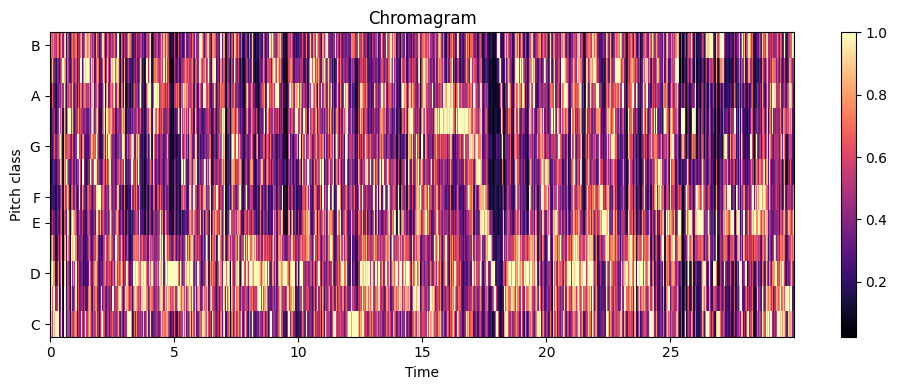

In [64]:
#plot_spectrogram(test_df.loc[0, 'spectrogram'])
plot_chromagram(test_df.loc[3, 'chromagram'])